# Kaggle with ``Gluon`` and k-fold cross-validation

How have you done so far on the journey of  `Deep Learning---the Straight Dope`?

> It's time to get your hands dirty. 

Let's get started.



## Introduction

In this tutorial, we introduce how to use ``Gluon`` for competition on [Kaggle](https://www.kaggle.com). Specifically, we will take the [house price prediction problem](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) as a case study. 

We will provide a basic end-to-end pipeline for completing a common Kaggle challenge. We will demonstrate how to use ``pandas`` to pre-process the real-world data sets, such as:

* Handling categorical data
* Handling missing values
* Standardizing numerical features

Note that this tutorial only provides a very basic pipeline. We expect you to tweak the following code, such as re-designing models and fine-tuning parameters, to obtain a desirable score on Kaggle.


## House Price Prediction Problem on Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform for people who love machine learning. To submit the results, please register a [Kaggle](https://www.kaggle.com) account. Please note that, **Kaggle limits the number of daily submissions to 10**.


![](../img/kaggle.png)


We take the [house price prediction problem](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) as an example to demonstrate how to complete a Kaggle competition with ``Gluon``. Please learn details of the problem by clicking the [link to the house price prediction problem](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) before starting.

![](../img/house_pricing.png)




## Load the data set

There are separate training and testing data sets for this competition. Both data sets describe features of every house, such as type of the street, year of building, and basement conditions. Such features can be numeric, categorical, or even missing (`na`). Only the training dat set has the sale price of each house, which shall be predicted based on features of the testing data set.

The data sets can be downloaded via the [link to problem](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Specifically, you can directly access the [training data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv) and the [testing data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/test.csv) after logging in Kaggle.

We load the data via `pandas`. Please make sure that it is installed (``pip install pandas``).

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("../data/kaggle/house_pred_train.csv")
test = pd.read_csv("../data/kaggle/house_pred_test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

We can take a look at a few rows of the training data set.

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Here is the shapes of the data sets.

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

## Pre-processing data

We can use ``pandas`` to standardize the numerical features:

$$x_i = \frac{x_i - \mathbb{E} x_i}{\text{std}(x_i)}$$

In [5]:
numeric_feas = all_X.dtypes[all_X.dtypes != "object"].index
all_X[numeric_feas] = all_X[numeric_feas].apply(
    lambda x: (x - x.mean()) / (x.std()))

Let us transform categorical values to numerical ones.

In [6]:
all_X = pd.get_dummies(all_X, dummy_na=True)

We can approximate the missing values by the mean values of the current feature.

In [7]:
all_X = all_X.fillna(all_X.mean())

Let us convert the formats of the data sets.

In [8]:
num_train = train.shape[0]

X_train = all_X[:num_train].as_matrix()
X_test = all_X[num_train:].as_matrix()
y_train = train.SalePrice.as_matrix()

## Loading data in `NDArray`

To facilitate the interations with ``Gluon``, we need to load data in the `NDArray` format.

In [9]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

We define the loss function to be the squared loss.

In [10]:
square_loss = gluon.loss.L2Loss()

Below defines the root mean square loss between the logarithm of the predicted values and the true values used in the competition.

In [11]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

## Define the model

We define a **basic** linear regression model here. This may be modified to achieve better results on Kaggle. 

In [12]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

We define the training function.

In [13]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs, 
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:    
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

## $K$-Fold Cross-Validation

We described the [overfitting problem](../chapter02_supervised-learning/regularization-scratch.ipynb), where we cannot rely on the training loss to infer the testing loss. In fact, when we fine-tune the parameters, we typically rely on $k$-fold cross-validation.

> In $k$-fold cross-validation, we divide the training data sets into $k$ subsets, where one set is used for the validation and the remaining $k-1$ subsets are used for training.

We care about the average training loss and average testing loss of the $k$ experimental results. Hence, we can define the $k$-fold cross-validation as follows.

In [14]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test, 
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

## Train and cross-validate the model

The following parameters can be fine-tuned.

In [15]:
k = 5
epochs = 100
verbose_epoch = 95
learning_rate = 5
weight_decay = 0.0

Given the above parameters, we can train and cross-validate our model.

Epoch 96, train loss: 0.201977
Epoch 97, train loss: 0.199836
Epoch 98, train loss: 0.197880
Epoch 99, train loss: 0.196004


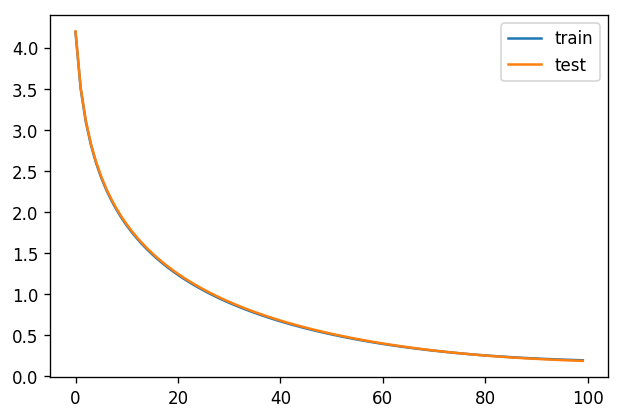

Test loss: 0.188862
Epoch 96, train loss: 0.198065
Epoch 97, train loss: 0.195875
Epoch 98, train loss: 0.193800
Epoch 99, train loss: 0.191871


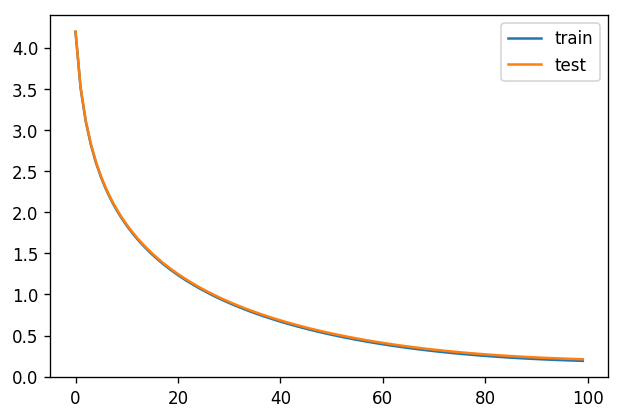

Test loss: 0.211622
Epoch 96, train loss: 0.199124
Epoch 97, train loss: 0.197008
Epoch 98, train loss: 0.194984
Epoch 99, train loss: 0.193029


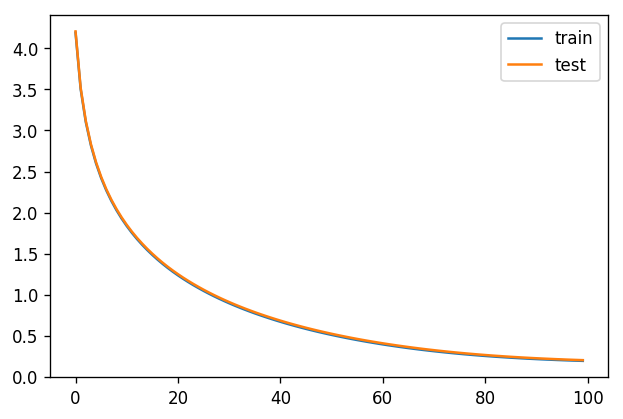

Test loss: 0.201633
Epoch 96, train loss: 0.201531
Epoch 97, train loss: 0.199355
Epoch 98, train loss: 0.197308
Epoch 99, train loss: 0.195344


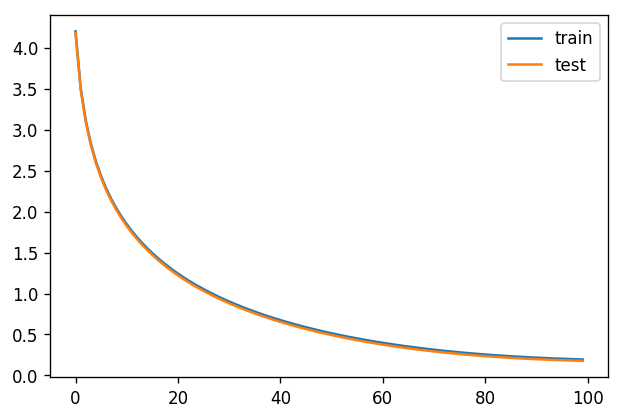

Test loss: 0.178342
Epoch 96, train loss: 0.197033
Epoch 97, train loss: 0.194821
Epoch 98, train loss: 0.192686
Epoch 99, train loss: 0.190709


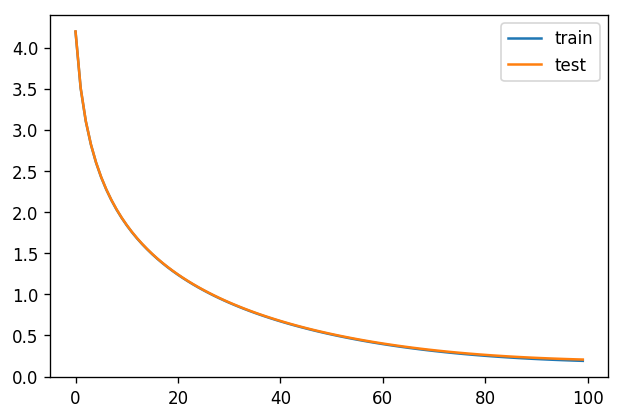

Test loss: 0.206771
5-fold validation: Avg train loss: 0.193391, Avg test loss: 0.197446


In [16]:
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

After fine-tuning, even though the training loss can be very low, but the validation loss for the $k$-fold cross validation can be very high. Thus, when the training loss is very low, we need to observe whether the validation loss is reduced at the same time and watch out for overfitting. We often rely on $k$-fold cross-validation to fine-tune parameters.

## Make predictions and submit results on Kaggle

Let us define the prediction function.

In [17]:
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch, 
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

After fine-tuning parameters, we can predict and submit results on Kaggle.

Epoch 96, train loss: 0.171171
Epoch 97, train loss: 0.170597
Epoch 98, train loss: 0.170039
Epoch 99, train loss: 0.169555


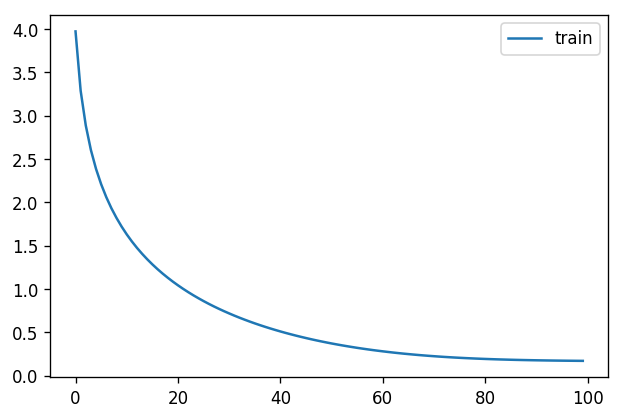

In [18]:
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
      weight_decay)

After executing the above code, a `submission.csv` file will be generated.  It is in the required format by Kaggle. Now, we can submit our predicted sales prices of houses based on the testing data set and compare them with the true prices on Kaggle. You need to log in Kaggle, open the [link to the house prediction problem]((https://www.kaggle.com/c/house-prices-advanced-regression-techniques)), and click the `Submis Predictions` button.


![](../img/kaggle_submit.png)




You may click the `Upload Submission File` button to select your results. Then click `Make Submission` at the bottom to view your results.

![](../img/kaggle_submit2.png)

Just a kind reminder again, **Kaggle limits the number of daily submissions to 10**.


## Exercise:

* What loss can you obtain on Kaggle by using this tutorial?
* By re-designing and fine-tuning the model and $k$-fold cross-validation, can you beat [the 0.14765 baseline](https://www.kaggle.com/zubairahmed/randomforestregressor-with-score-of-0-14765/) achieved by Random Forest regressor (a powerful model) on Kaggle?

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)